In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

In [ ]:
ls

'My Drive'/


In [ ]:
cd My Drive

/gdrive/My Drive


In [ ]:
cd data

/gdrive/My Drive/data


In [ ]:
ls

dataset.json  demo_image.jpeg


In [ ]:
from pathlib import Path
from tqdm import tqdm
import numpy as np 
import shutil
import json
import urllib
import PIL.Image as Image
import cv2
from IPython.display import display

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
rcParams['figure.figsize'] = 16, 10

np.random.seed(42)

In [ ]:
clothing = []
with open("dataset.json") as f:
  for line in f:
    clothing.append(json.loads(line))


In [ ]:
len(clothing)

504

In [ ]:
clothing[0]

{'annotation': [{'imageHeight': 312,
   'imageWidth': 147,
   'label': ['Tops'],
   'notes': '',
   'points': [{'x': 0.02040816326530612, 'y': 0.2532051282051282},
    {'x': 0.9931972789115646, 'y': 0.8108974358974359}]}],
 'content': 'http://com.dataturks.a96-i23.open.s3.amazonaws.com/2c9fafb063ad2b650163b00a1ead0017/4bb8fd9d-8d52-46c7-aa2a-9c18af10aed6___Data_xxl-top-4437-jolliy-original-imaekasxahykhd3t.jpeg',
 'extras': None}

In [ ]:
for c in clothing:
  if len(c['annotation']) > 1:
    display(c)

{'annotation': [{'imageHeight': 312,
   'imageWidth': 265,
   'label': ['Jackets'],
   'notes': '',
   'points': [{'x': 0, 'y': 0.6185897435897436},
    {'x': 0.026415094339622643, 'y': 0.6185897435897436}]},
  {'imageHeight': 312,
   'imageWidth': 265,
   'label': ['Skirts'],
   'notes': '',
   'points': [{'x': 0.01509433962264151, 'y': 0.03205128205128205},
    {'x': 1, 'y': 0.9839743589743589}]}],
 'content': 'http://com.dataturks.a96-i23.open.s3.amazonaws.com/2c9fafb063ad2b650163b00a1ead0017/b3be330c-c211-45bb-b244-11aef08021c8___Data_free-sk-5108-mudrika-original-imaf4fz626pegq9f.jpeg',
 'extras': None}

In [ ]:
categories = []

for c in clothing:
  for a in c['annotation']:
    categories.extend(a['label'])

categories = list(set(categories))
categories

['Jeans',
 'Jackets',
 'Trousers',
 'Skirts',
 'sunglasses',
 'Tshirts',
 'Shoes',
 'Tops',
 'Shirts']

In [ ]:
len(categories)

9

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
train_clothing, val_clothing = train_test_split(clothing, test_size = 0.1)


In [ ]:
len(train_clothing), len(val_clothing)

(453, 51)

In [ ]:
row = train_clothing[4]

img = urllib.request.urlopen(row['content'])
img = Image.open(img)
img = img.convert('RGB')

img.save("demo_image.jpeg", "JPEG")

OSError: ignored

In [ ]:
ls

dataset.json  demo_image.jpeg


In [ ]:
img = cv2.cvtColor(cv2.imread("demo_image.jpeg"), cv2.COLOR_BGR2RGB)

In [ ]:
img.shape

(312, 216, 3)

In [ ]:
row

{'annotation': [{'imageHeight': 312,
   'imageWidth': 216,
   'label': ['Skirts'],
   'notes': '',
   'points': [{'x': 0.07407407407407407, 'y': 0.09294871794871795},
    {'x': 0.9768518518518519, 'y': 0.9935897435897436}]}],
 'content': 'http://com.dataturks.a96-i23.open.s3.amazonaws.com/2c9fafb063ad2b650163b00a1ead0017/f1de52ad-e4fb-4058-be8a-8c417b6e7791___Data_dl3208-decot-paradise-free-original-imaenr8farngveuu.jpeg',
 'extras': None}

In [ ]:
for a in row['annotation']:
  for label in a['label']:

    w = a['imageWidth']
    h = a['imageHeight']

    points = a['points']
    p1, p2 = points

    x1,y1 = p1['x']*w, p1['y']*h
    x2,y2 = p2['x']*w, p2['y']*h

    cv2.rectangle(
        img,
        (int(x1), int(y1)),
        (int(x2), int(y2)),
        color=(0, 255, 0),
        thickness = 2
    )

    ((label_width, label_height), _) = cv2.getTextSize(
    label, 
    fontFace=cv2.FONT_HERSHEY_PLAIN,
    fontScale=1.75,
    thickness =2
    )

    cv2.rectangle(
        img,
        (int(x1), int(y1)),
        (int(x1 +label_width + label_width *0.05), 
         int(y1 + label_height + label_height*0.25)),
        color=(0, 255, 0),
        thickness = cv2.FILLED
    )

    cv2.putText(
        img,
        label,
        org=(int(x1), int(y1 + label_height + label_height *0.25)),
        fontFace= cv2.FONT_HERSHEY_PLAIN,
        fontScale =1.75,
        color=(255,255, 255),
        thickness =2
    )


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

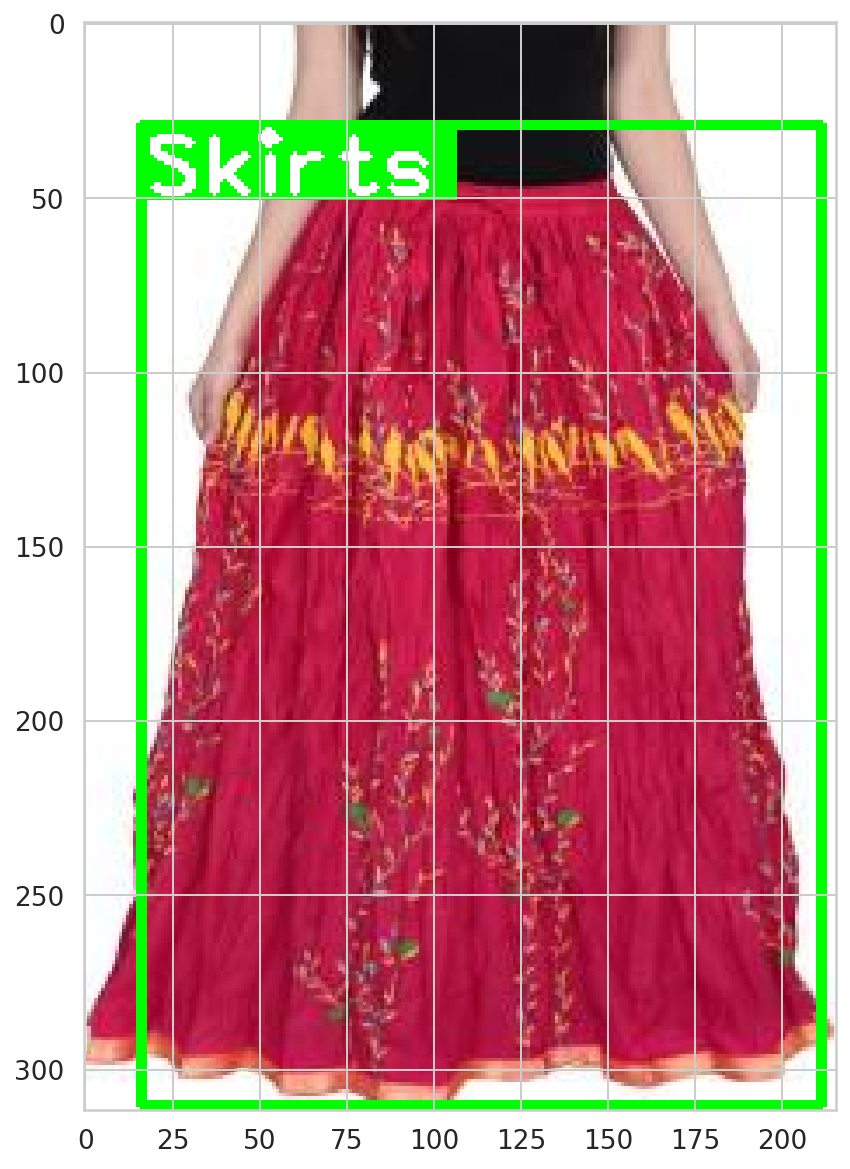

In [ ]:
plt.imshow(img)
plt

## Convert to YOLO format
### YOLO v5 requires the dataset to be in the darknet format. Here's an outline of what it looks like after:

#### One text with labels per image
#### One row per Object
#### Each row contains: classes
#### Box coordinates must be normalized between 0 and 1

In [ ]:
def create_dataset(clothing, dataset_type):
  
  images_path = Path(f"clothing/images/{dataset_type}")
  images_path.mkdir(parents=True, exist_ok = True)

  labels_path = Path(f"clothing/labels/{dataset_type}")
  labels_path.mkdir(parents=True, exist_ok = True)

  for img_id, row in enumerate(tqdm(clothing)):

    image_name = f"{img_id}.jpeg"

    img = urllib.request.urlopen(row["content"])
    img = Image.open(img)
    img = img.convert("RGB")

    img.save(str(images_path / image_name), "JPEG")

    label_name = f"{img_id}.txt"

    with (labels_path / label_name).open(mode="w") as label_file:

      for a in row['annotation']:

        for label in a ['label']:

          category_idx = categories.index(label)

          points = a['points']

          p1, p2 = points

          x1,y1 = p1['x'], p1['y']
          x2,y2 = p2['x'], p2['y']

          bbox_width = x2 - x1
          bbox_height = y2 - y1

          label_file.write(
              f"{category_idx}{x1 + bbox_width / 2}{y1 + bbox_height / 2}{bbox_width}{bbox_height}\n"
          )


In [ ]:
create_dataset(train_clothing, "train")
create_dataset(val_clothing, "val")


100%|██████████| 51/51 [00:11<00:00,  4.39it/s]


In [ ]:
!sudo apt-get install tree

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 21 not upgraded.
Need to get 40.7 kB of archives.
After this operation, 105 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tree amd64 1.7.0-5 [40.7 kB]
Fetched 40.7 kB in 0s (97.3 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package tree.
(Reading database ... 144611 files and directories currently instal

In [ ]:
!tree clothing -L 2

clothing
├── images
│   ├── train
│   └── val
└── labels
    ├── train
    └── val

6 directories, 0 files
